<a href="https://colab.research.google.com/github/HtmMhmd/kaggle-housing-prices/blob/main/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tommy011","key":"2a34fc4484bbd31062ee39c402c8b042"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
!mkdir Dataset
!unzip -q /content/gtsrb-german-traffic-sign.zip -d /content/Dataset
!rm /content/gtsrb-german-traffic-sign.zip

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import tensorflow_hub as hub
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.utils import shuffle

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [7]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2997951202448749494
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5904546922488814263
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [8]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# **Data Exploration**

In [9]:
meta_dataset = pd.read_csv('/content/Dataset/Meta.csv')
meta_dataset.head(10)

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22
5,Meta/12.png,12,2,2,2.3
6,Meta/13.png,13,4,0,2.1
7,Meta/14.png,14,3,0,2.2
8,Meta/15.png,15,1,0,3.1
9,Meta/16.png,16,1,0,3.3


In [10]:
#classes labels represented in dictionary
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'
          }

# Preprocess the dataframe

In [11]:
def prepare_inputs(dataset):
    dataset_cp = dataset.copy()
    files_path = '/content/Dataset/'
    dataset_cp['Path'] = files_path + dataset_cp['Path']   #modifing the paths of the images to the actual path

    dataset_cp['Target'] = ''
    for index in range(len(dataset_cp)):
        dataset_cp.loc[index,'Target'] = classes[dataset_cp['ClassId'][index]]
    return dataset_cp

In [12]:
meta_dataset_v2 = prepare_inputs(meta_dataset)
meta_dataset_v2.head()

,Path,ClassId,ShapeId,ColorId,SignId,Target
0,/content/Dataset/Meta/27.png,27,0,0,1.32,Pedestrians
1,/content/Dataset/Meta/0.png,0,1,0,3.29,Speed limit (20km/h)
2,/content/Dataset/Meta/1.png,1,1,0,3.29,Speed limit (30km/h)
3,/content/Dataset/Meta/10.png,10,1,0,3.27,No passing veh over 3.5 tons
4,/content/Dataset/Meta/11.png,11,0,0,1.22,Right-of-way at intersection


# Viewing the images

In [13]:
def image_viewer(dataset, index, ax):
    image_path =  dataset['Path'][index]
    image      =  Image.open(image_path)
    ax.imshow(image)
def plot_some_images(dataset, title):
    fig, axs = plt.subplots(nrows = 4,ncols = 10,figsize=(20,8))
    for ind, ax in enumerate(axs.flat):
            index = random.randrange(len(dataset))
            image_viewer(dataset, index, ax)
            ax.set_title(dataset['Target'][index], fontsize = 8)
            ax.axis('off')
            fig.suptitle(title, fontsize = 15)
    plt.show()

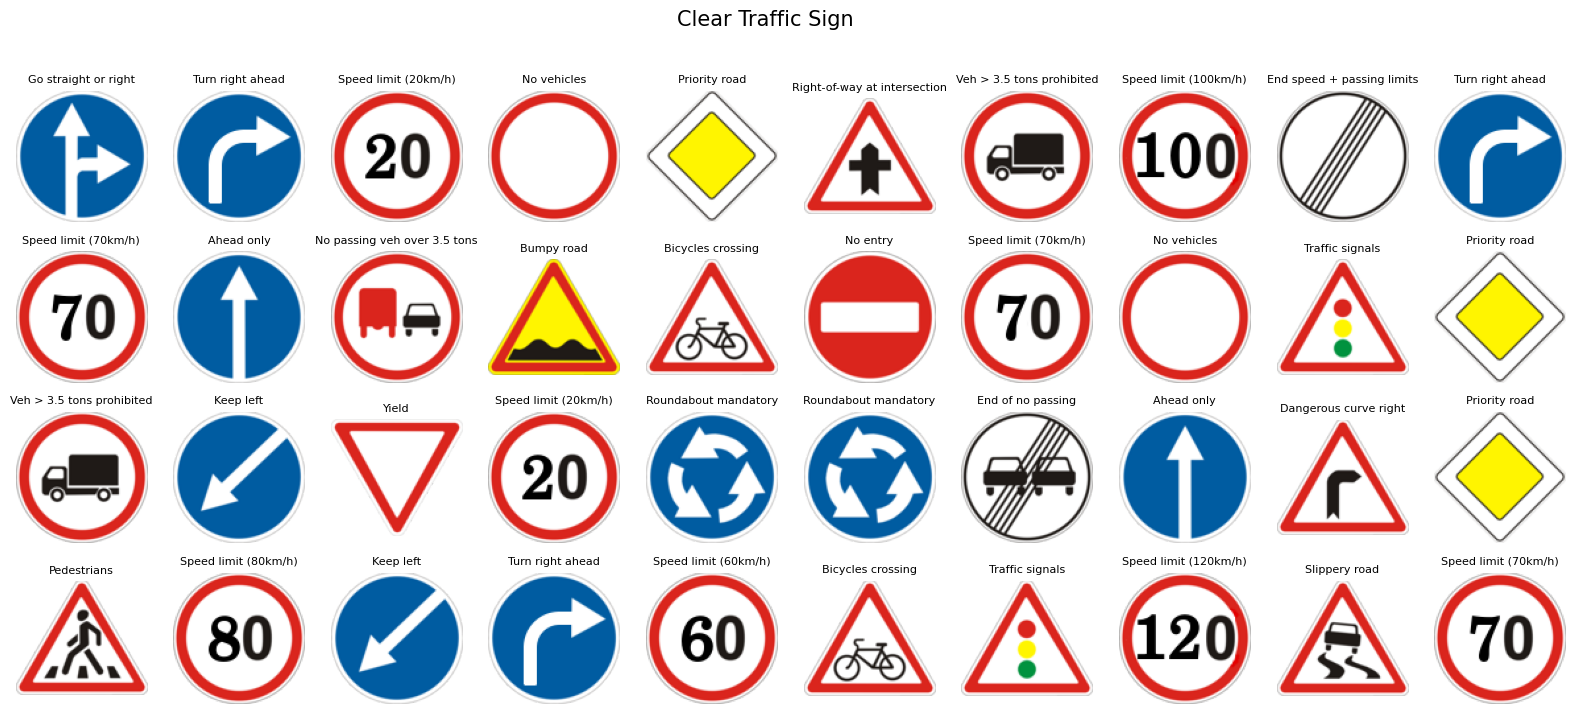

In [14]:
plot_some_images(meta_dataset_v2, 'Clear Traffic Sign')

# **Implmentation of quick and dirty model**

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    #rescale = 1/255.0,
    rotation_range     = 25,
    width_shift_range  = 0.1,
    height_shift_range = 0.1,
    shear_range        = 0.1,
    horizontal_flip    = True,
    vertical_flip      = True,)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
    #rescale = 1/255.0)

In [16]:
def generate_images(dataset ,
                    y_label_col,
                    x_col ,
                    size ,
                    batch_size,
                    generator):

    if generator == 0:
            generator =    train_generator

    else :
            generator =    test_generator

    images = generator.flow_from_dataframe(
              dataframe    =  dataset,
              x_col        =   x_col,
              y_col        =   y_label_col,
              target_size  =  (size, size),
              color_mode   =  'rgb',
              class_mode   =  'categorical',
              batch_size   =   batch_size,
              shuffle      =   True,
              random_seed = 42)
    labels = shuffle(dataset[y_label_col].copy(), random_state=1)
    return images, labels

In [17]:
y_label_col = 'Target'
x_col = 'Path'
size = 30

batch_size = 22
quick_train_images, quick_train_label = generate_images(meta_dataset_v2, y_label_col, x_col, size, batch_size, 0)

Found 43 validated image filenames belonging to 43 classes.


loading the basline model

In [18]:
def Model_init(trans_model,
            input_image_size,
               dence1,
               dence2,
               regularizer,
               drop):

      trans_arc = trans_model(weights = "imagenet", include_top = False,
                        input_shape=(input_image_size, input_image_size,3), pooling='max')
      for l in trans_arc.layers:
        l.trainable = False
      inputs = trans_arc.input
      flatten = trans_arc.output

      x = tf.keras.layers.Flatten()(flatten)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Dense(dence1, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.L2(regularizer))(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Dropout(drop)(x)
      x = tf.keras.layers.Dense(dence2, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(regularizer))(x)
      x =tf.keras.layers.BatchNormalization()(x)
      outputs = tf.keras.layers.Dense(43, activation='softmax')(x)

      model = tf.keras.Model(inputs=inputs, outputs=outputs)


      return model

In [19]:
trans_model= tf.keras.applications.EfficientNetB0
model = Model_init(trans_model,input_image_size = 32, dence1=256,dence2=256, regularizer=0.0, drop= 0.0)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['normalization[0][0]']          
                                                                                              

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
def Model_compile_param(model = model,
                  initial_learning_rate      = 1e-3,
                  learning_rate_decay_steps  =300,
                  learning_rate_decay_rate   =0.9,
                  Adam_beta_1                =0.9,
                  Adam_beta_2                =0.999,):

    loss = [tf.keras.losses.CategoricalCrossentropy()]

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps  =learning_rate_decay_steps,
        decay_rate   =learning_rate_decay_rate,
        staircase    =True)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate= lr_schedule,
        beta_1       =Adam_beta_1,
        beta_2       =Adam_beta_2,
        epsilon      =1e-07,
    )
    metrics= ['accuracy', f1_m ]

    model.compile( optimizer=optimizer,
                loss= loss,
                metrics=metrics)
    return model ,lr_schedule

In [22]:
model ,lr_schedule= Model_compile_param()

In [23]:
history = model.fit(
      quick_train_images,
      verbose = True,
      epochs=20,
            callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/20
2/2 [==============================] - 11s 51ms/step - loss: nan - accuracy: 0.0233 - f1_m: nan - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 0s 29ms/step - loss: nan - accuracy: 0.0233 - f1_m: nan - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 0s 29ms/step - loss: nan - accuracy: 0.0233 - f1_m: nan - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 0s 36ms/step - loss: nan - accuracy: 0.0233 - f1_m: nan - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 0s 33ms/step - loss: nan - accuracy: 0.0233 - f1_m: nan - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 0s 27ms/step - loss: nan - accuracy: 0.0233 - f1_m: nan - lr: 0.0010
Epoch 7/20
2/2 [==============================] - 0s 29ms/step - loss: nan - accuracy: 0.0233 - f1_m: nan - lr: 0.0010
Epoch 8/20
2/2 [==============================] - 0s 28ms/step - loss: nan - accuracy: 0.0233 - f1_m: nan - lr: 0.0010
Epoch 9/20
2/2 [==============================]

# Exploring train dataset

In [24]:
train_dataset = pd.read_csv('/content/Dataset/Train.csv')
train_dataset.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [25]:
test_dataset = pd.read_csv('/content/Dataset/Test.csv')
test_dataset.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [26]:
train_dataset   = prepare_inputs(train_dataset)
test_dataset    = prepare_inputs(test_dataset)

In [27]:
train_dataset.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Target
0,27,26,5,5,22,20,20,/content/Dataset/Train/20/00020_00000_00000.png,Dangerous curve right
1,28,27,5,6,23,22,20,/content/Dataset/Train/20/00020_00000_00001.png,Dangerous curve right
2,29,26,6,5,24,21,20,/content/Dataset/Train/20/00020_00000_00002.png,Dangerous curve right
3,28,27,5,6,23,22,20,/content/Dataset/Train/20/00020_00000_00003.png,Dangerous curve right
4,28,26,5,5,23,21,20,/content/Dataset/Train/20/00020_00000_00004.png,Dangerous curve right


In [28]:
test_dataset.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Target
0,53,54,6,5,48,49,16,/content/Dataset/Test/00000.png,Veh > 3.5 tons prohibited
1,42,45,5,5,36,40,1,/content/Dataset/Test/00001.png,Speed limit (30km/h)
2,48,52,6,6,43,47,38,/content/Dataset/Test/00002.png,Keep right
3,27,29,5,5,22,24,33,/content/Dataset/Test/00003.png,Turn right ahead
4,60,57,5,5,55,52,11,/content/Dataset/Test/00004.png,Right-of-way at intersection


# Plotting Train and Test Images

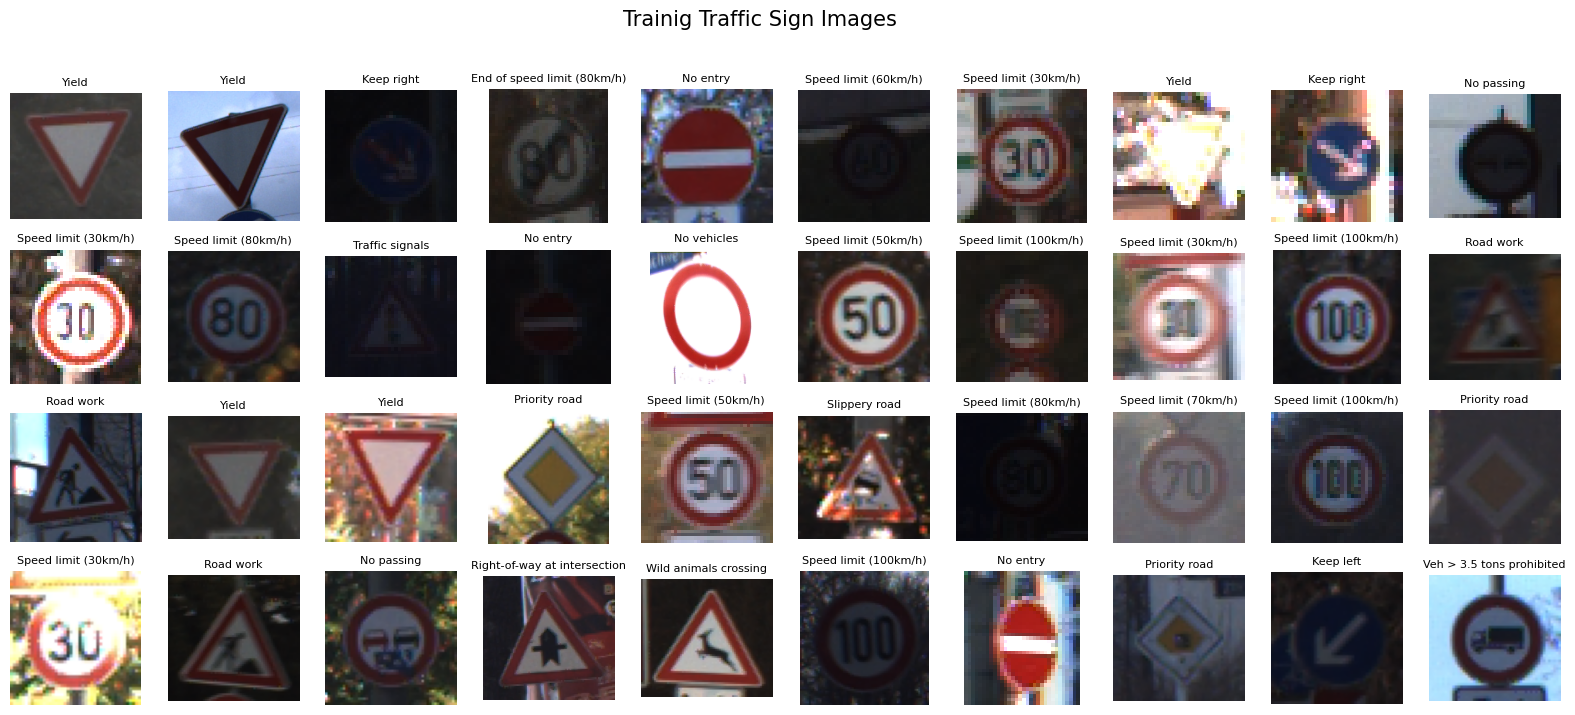

In [29]:
plot_some_images(train_dataset, 'Trainig Traffic Sign Images')

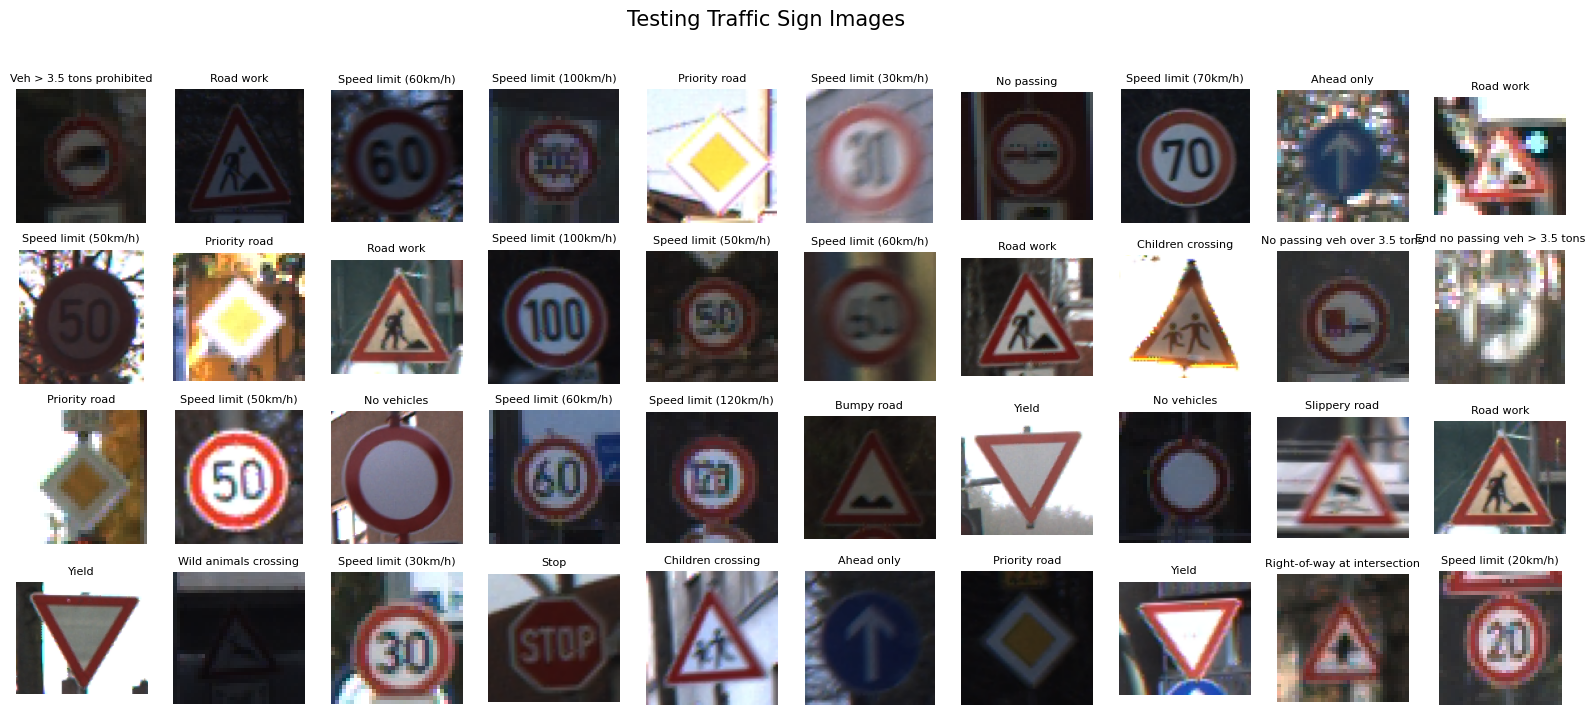

In [30]:
plot_some_images(test_dataset, 'Testing Traffic Sign Images')

In [31]:
train_dataset['Target'].unique()

array(['Dangerous curve right', 'Speed limit (20km/h)',
       'Speed limit (30km/h)', 'Speed limit (50km/h)',
       'Speed limit (60km/h)', 'Speed limit (70km/h)',
       'Speed limit (80km/h)', 'End of speed limit (80km/h)',
       'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing',
       'No passing veh over 3.5 tons', 'Right-of-way at intersection',
       'Priority road', 'Yield', 'Stop', 'No vehicles',
       'Veh > 3.5 tons prohibited', 'No entry', 'General caution',
       'Dangerous curve left', 'Double curve', 'Bumpy road',
       'Slippery road', 'Road narrows on the right', 'Road work',
       'Traffic signals', 'Pedestrians', 'Children crossing',
       'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing',
       'End speed + passing limits', 'Turn right ahead',
       'Turn left ahead', 'Ahead only', 'Go straight or right',
       'Go straight or left', 'Keep right', 'Keep left',
       'Roundabout mandatory', 'End of no passing',
       'End n

# Plotting the data distribution

In [32]:
def get_class_counts(dataset):
    class_counts = {}
    for class_id in dataset['Target'].unique():
        counts                 = len(dataset[dataset['Target'] == class_id])
        class_counts[class_id] = counts
    return class_counts

In [33]:
train_class_counts = get_class_counts(train_dataset)
test_class_counts  = get_class_counts(test_dataset)

In [34]:
def plot_class_counts(class_counts, title):
    plt.figure(figsize=(20,5))
    class_counts_cp =  dict(sorted(class_counts.items(), key=lambda x:x[1]))
    names = list(class_counts_cp.keys())
    values  = list(class_counts_cp.values())
    plt.bar(range(len(class_counts_cp)), values, tick_label=names)

    plt.xlabel('Target', fontsize= 10)
    plt.ylabel('Counts', fontsize= 10)
    plt.title(title +'-dataset class counts', fontsize= 15)
    plt.xticks(rotation = 90)
    plt.show()

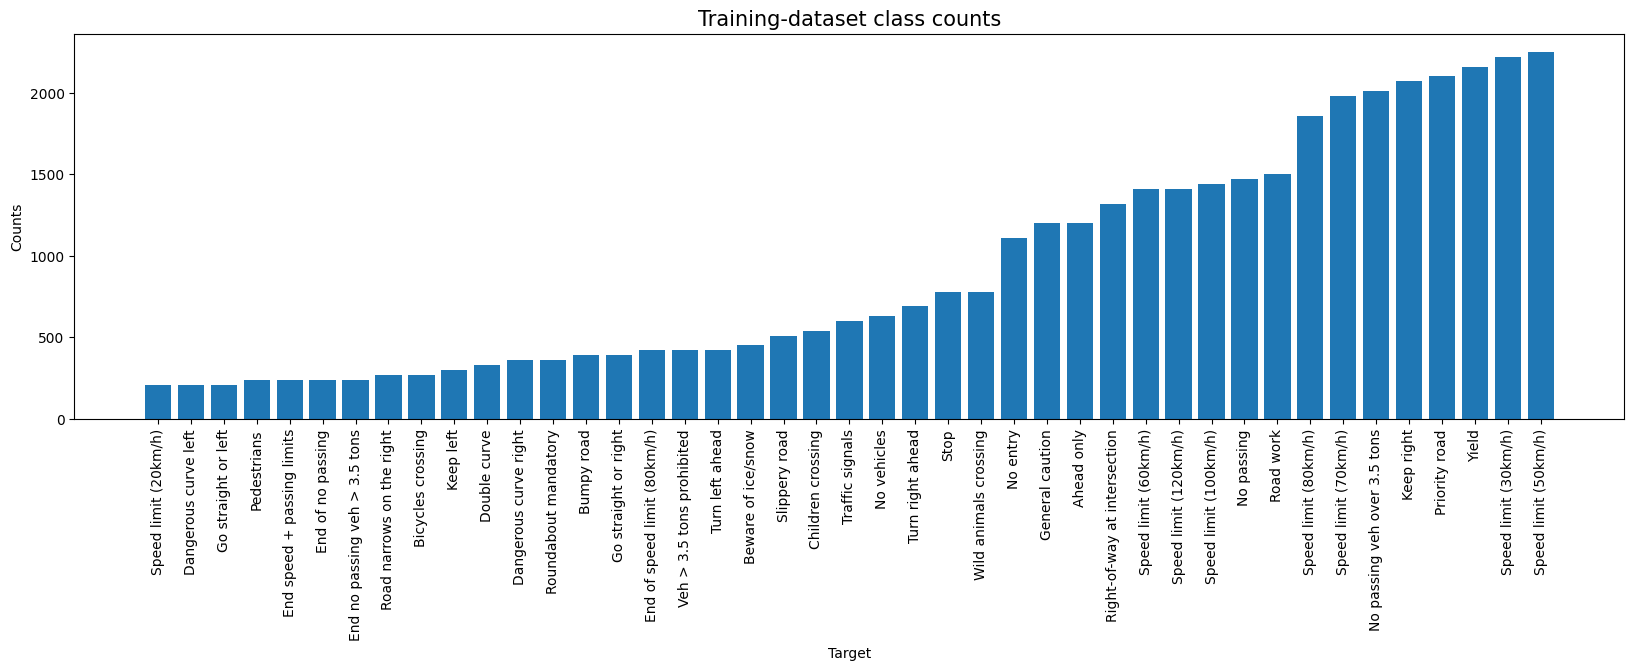

In [35]:
plot_class_counts(train_class_counts, 'Training')

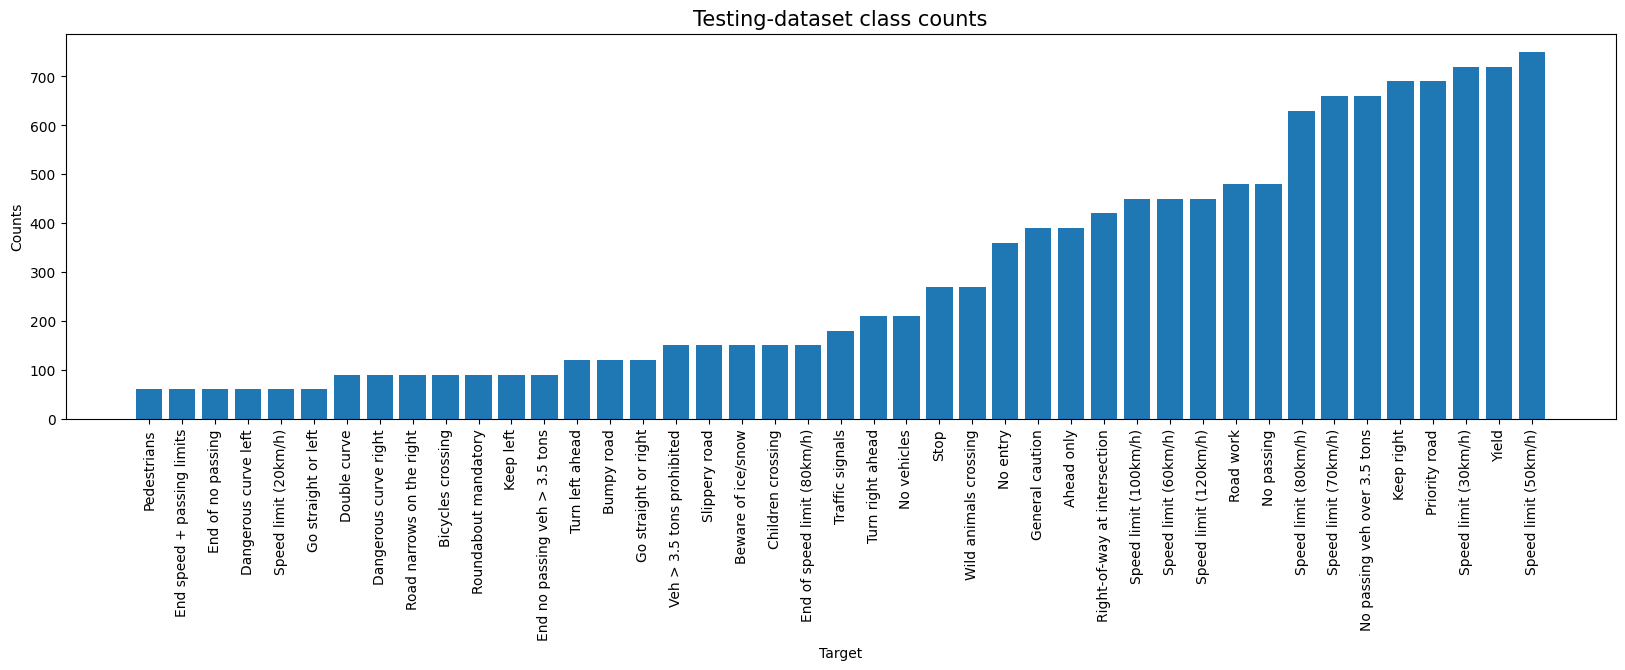

In [36]:
plot_class_counts(test_class_counts, 'Testing')

**its clear that we are dealing with imbalanced dataset**

# Splitting the Train dataset

In [37]:
x_train, x_val = train_test_split(train_dataset,train_size=0.6, random_state=42, shuffle=True)

In [38]:
sub_train_class_counts = get_class_counts(x_train)
sub_val_class_counts  = get_class_counts(x_val)

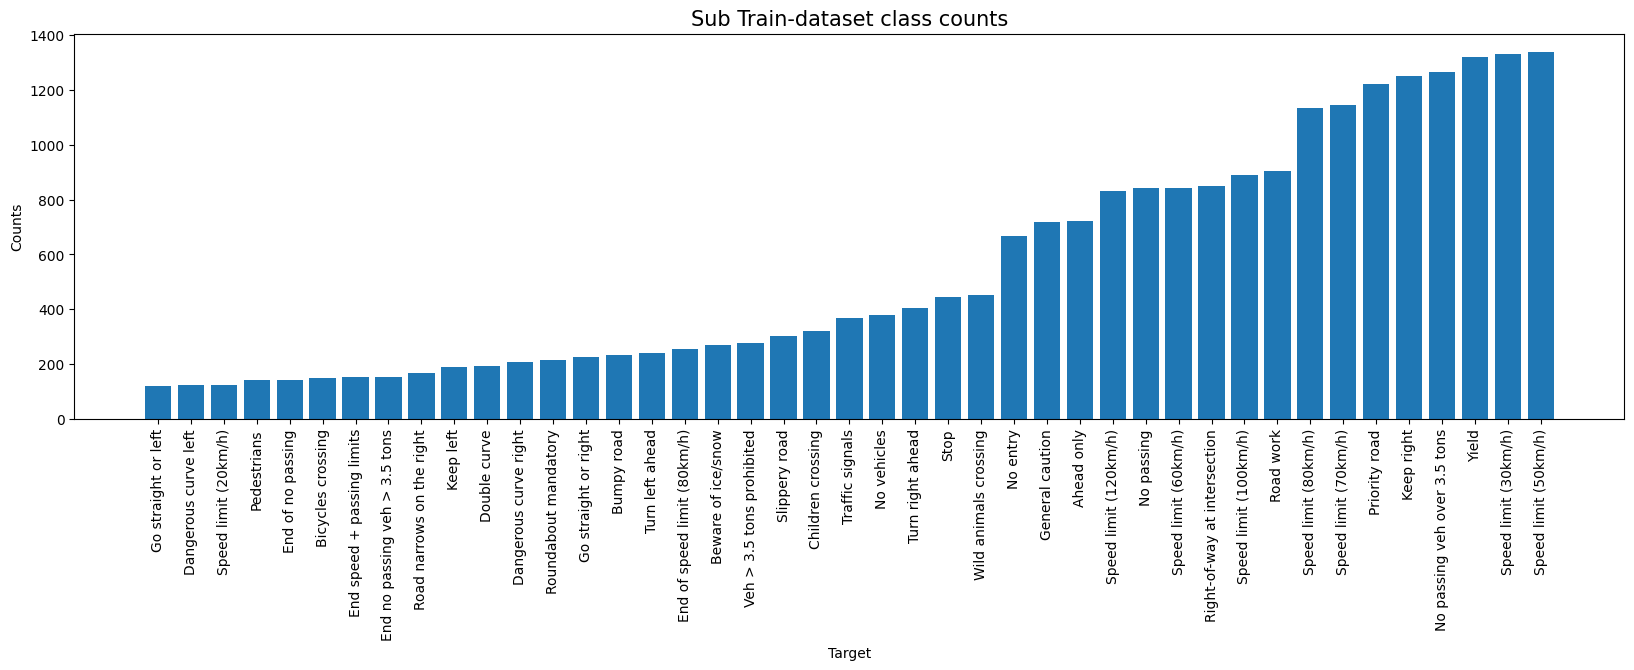

In [39]:
plot_class_counts(sub_train_class_counts, 'Sub Train')

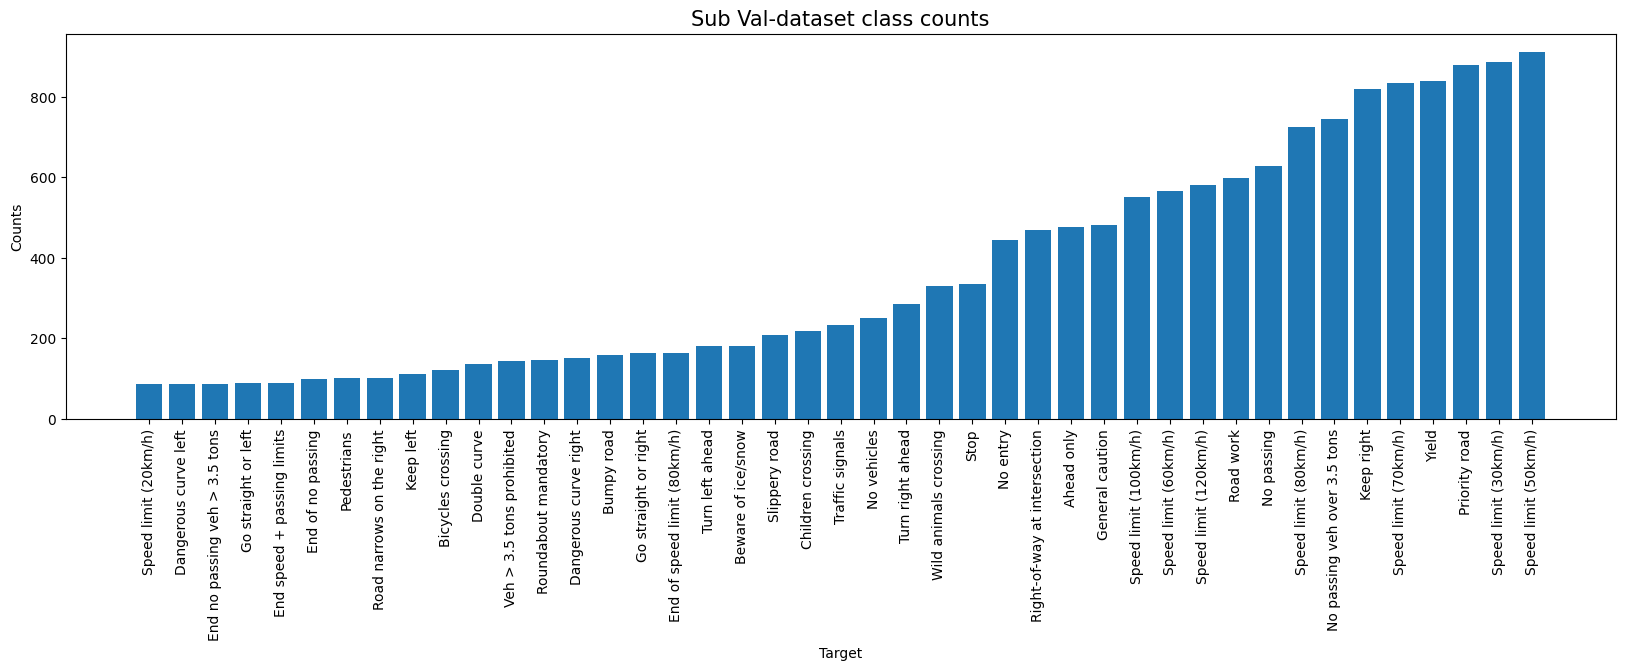

In [40]:
plot_class_counts(sub_val_class_counts, 'Sub Val')

**nearly same distribution**

# Imbalance handeling

In [41]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes= np.unique(x_train['Target']),
                                     y= x_train['Target'])

classes = (np.unique(x_train['Target']))
class_weights_forplot = dict(zip(classes, class_weights))

In [42]:
class_weights = dict(zip(range(43), class_weights))

In [43]:
class_weights

{0: 0.7566985107272669,
 1: 2.0262704565030147,
 2: 3.671765256750429,
 3: 2.3683680660424846,
 4: 1.7043396363109469,
 5: 4.44791075817735,
 6: 2.6302549194991056,
 7: 2.820067130184608,
 8: 3.5757713938288496,
 9: 3.8527677694071407,
 10: 2.137082122093023,
 11: 3.6231326043431387,
 12: 0.7609082381861112,
 13: 4.521429944262925,
 14: 2.4101014240344227,
 15: 2.9100692726373083,
 16: 0.43767441860465117,
 17: 0.8202294201736341,
 18: 0.6489834202322823,
 19: 0.4321429883537235,
 20: 1.439718482252142,
 21: 3.9078073089700998,
 22: 0.44806963411614575,
 23: 0.64288251851447,
 24: 3.2565060908084162,
 25: 0.6058615982899379,
 26: 2.55650945446642,
 27: 1.8115663021715693,
 28: 0.6154027258220629,
 29: 0.6591482207901372,
 30: 4.44791075817735,
 31: 0.41042237303511925,
 32: 0.4085832884658805,
 33: 0.6482144825305852,
 34: 0.47697735244621964,
 35: 0.4824453467864321,
 36: 1.2294225241703685,
 37: 1.486665824064712,
 38: 2.2795542635658914,
 39: 1.3508469710020097,
 40: 1.9822210987529

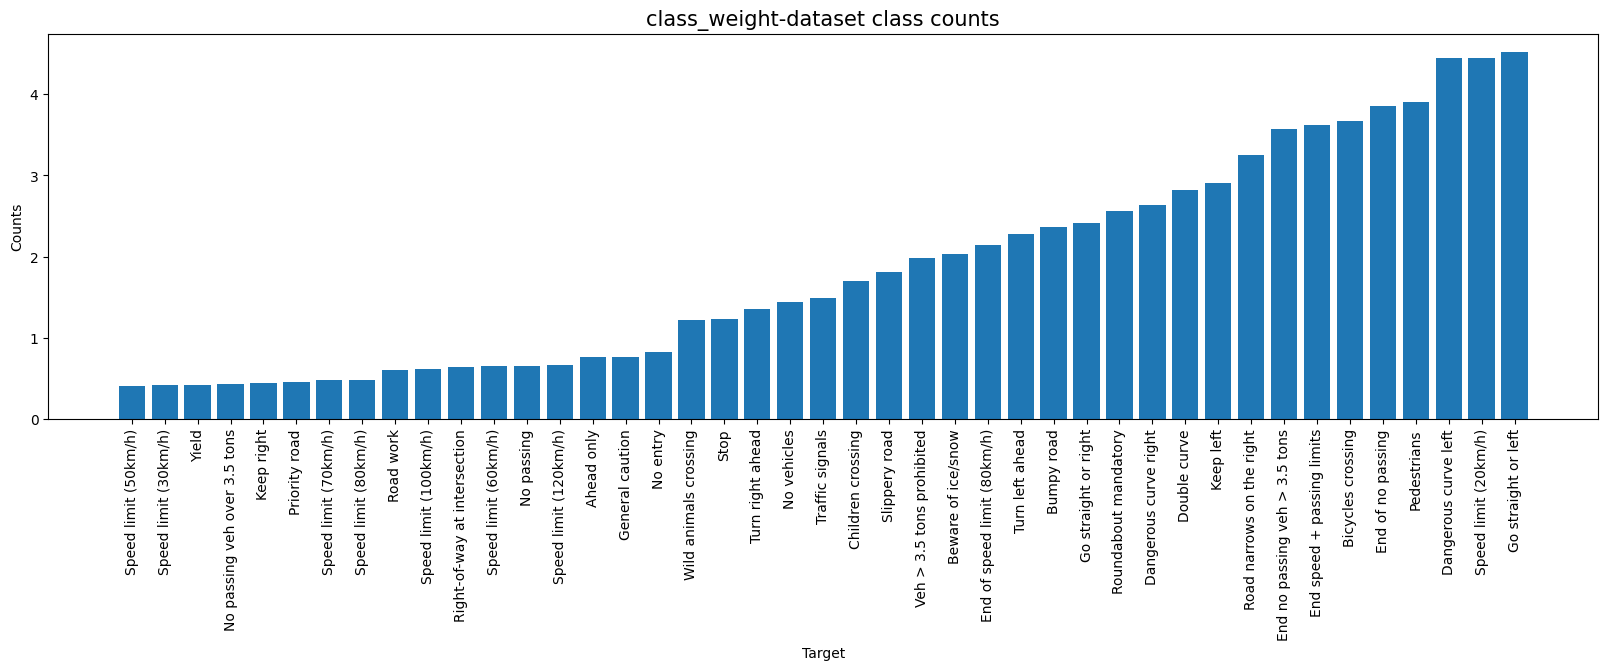

In [44]:
plot_class_counts(class_weights_forplot, 'class_weight')

# Training the model

In [71]:
y_label_col = 'Target'
x_col       = 'Path'
size        = 128
batch_size  = 1000

train_images, train_label = generate_images(x_train, y_label_col, x_col, size, batch_size, 0)
val_images  , val_label   = generate_images(x_val , y_label_col, x_col, size, batch_size, 1)

test_images  , test_label   = generate_images(test_dataset , y_label_col, x_col, size, batch_size, 1)

Found 23525 validated image filenames belonging to 43 classes.
Found 15684 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


In [46]:
train_images.class_indices.keys() == class_weights_forplot.keys()

True

In [85]:
input_image_size = 128
dence1           = 1080
dence2           = 1080
regularizer      = 0.00
drop             = 0.50


trans_model= tf.keras.applications.EfficientNetB0


model = Model_init(trans_model,
                    input_image_size,
                    dence1          ,
                    dence2          ,
                    regularizer     ,
                    drop)

In [ ]:
model.summary()

In [87]:
model ,lr_schedule= Model_compile_param(model = model,
                                        initial_learning_rate     = 5e-3,
                                        learning_rate_decay_steps  =24,
                                        learning_rate_decay_rate   =0.98,
                                        Adam_beta_1                =0.9,
                                        Adam_beta_2                =0.999,)

In [88]:
#os.mkdir("/content/checkpoints")
cb_csvlogger = tf.keras.callbacks.CSVLogger(
                                            filename='/content/checkpoints/training_log.csv',
                                            separator=',',
                                            append=False)

In [90]:
model.load_weights('/content/checkpoints/model.h5')

In [ ]:
history = model.fit(
      train_images                   ,
      validation_data=val_images     ,
      verbose         = True         ,
      epochs          =10            ,
      class_weight    = class_weights,
          callbacks=[
          tf.keras.callbacks.LearningRateScheduler(lr_schedule),
          tf.keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=5,min_delta=0.05,
              restore_best_weights=True),
              cb_csvlogger
                        ])

Epoch 1/10
24/24 [==============================] - 125s 5s/step - loss: 0.5275 - accuracy: 0.8135 - f1_m: 0.8173 - val_loss: 0.6570 - val_accuracy: 0.8119 - val_f1_m: 0.8161 - lr: 0.0050
Epoch 2/10
24/24 [==============================] - 121s 5s/step - loss: 0.4789 - accuracy: 0.8218 - f1_m: 0.8226 - val_loss: 0.6487 - val_accuracy: 0.8153 - val_f1_m: 0.8174 - lr: 0.0049
Epoch 3/10
24/24 [==============================] - 115s 5s/step - loss: 0.4182 - accuracy: 0.8322 - f1_m: 0.8336 - val_loss: 0.6632 - val_accuracy: 0.8123 - val_f1_m: 0.8170 - lr: 0.0048
Epoch 4/10
24/24 [==============================] - 116s 5s/step - loss: 0.3829 - accuracy: 0.8471 - f1_m: 0.8476 - val_loss: 0.5286 - val_accuracy: 0.8349 - val_f1_m: 0.8396 - lr: 0.0047
Epoch 5/10
24/24 [==============================] - 113s 5s/step - loss: 0.3663 - accuracy: 0.8487 - f1_m: 0.8512 - val_loss: 0.5488 - val_accuracy: 0.8302 - val_f1_m: 0.8359 - lr: 0.0046
Epoch 6/10
24/24 [==============================] - 113s 5s/

In [82]:
model.save_weights('/content/checkpoints/model.h5')

In [83]:
model.load_weights('/content/checkpoints/model.h5')

In [ ]:
objects = {'recall_m':recall_m,'precision_m':precision_m,'f1_m':f1_m}

In [ ]:
#import keras
#model =  keras.models.load_model('modelnew.h5',compile= True,custom_objects=objects)

In [ ]:
#new_model.summry()

# Evaluating the model

In [53]:
def plot_model_evaluation(model, test_data, n_classes):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    pred = model.predict(test_data)
    y_pred = np.argmax(pred, axis= 1)
    cm = confusion_matrix(test_data.labels, y_pred)

    clr = classification_report(test_data.labels, y_pred)

    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(n_classes) + 0.5, labels=list(test_data.class_indices.keys()), rotation=90)
    plt.yticks(ticks=np.arange(n_classes) + 0.5, labels=list(test_data.class_indices.keys()), rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)


    Test Loss: 1.33376
Test Accuracy: 69.11%
13/13 [==============================] - 11s 804ms/step


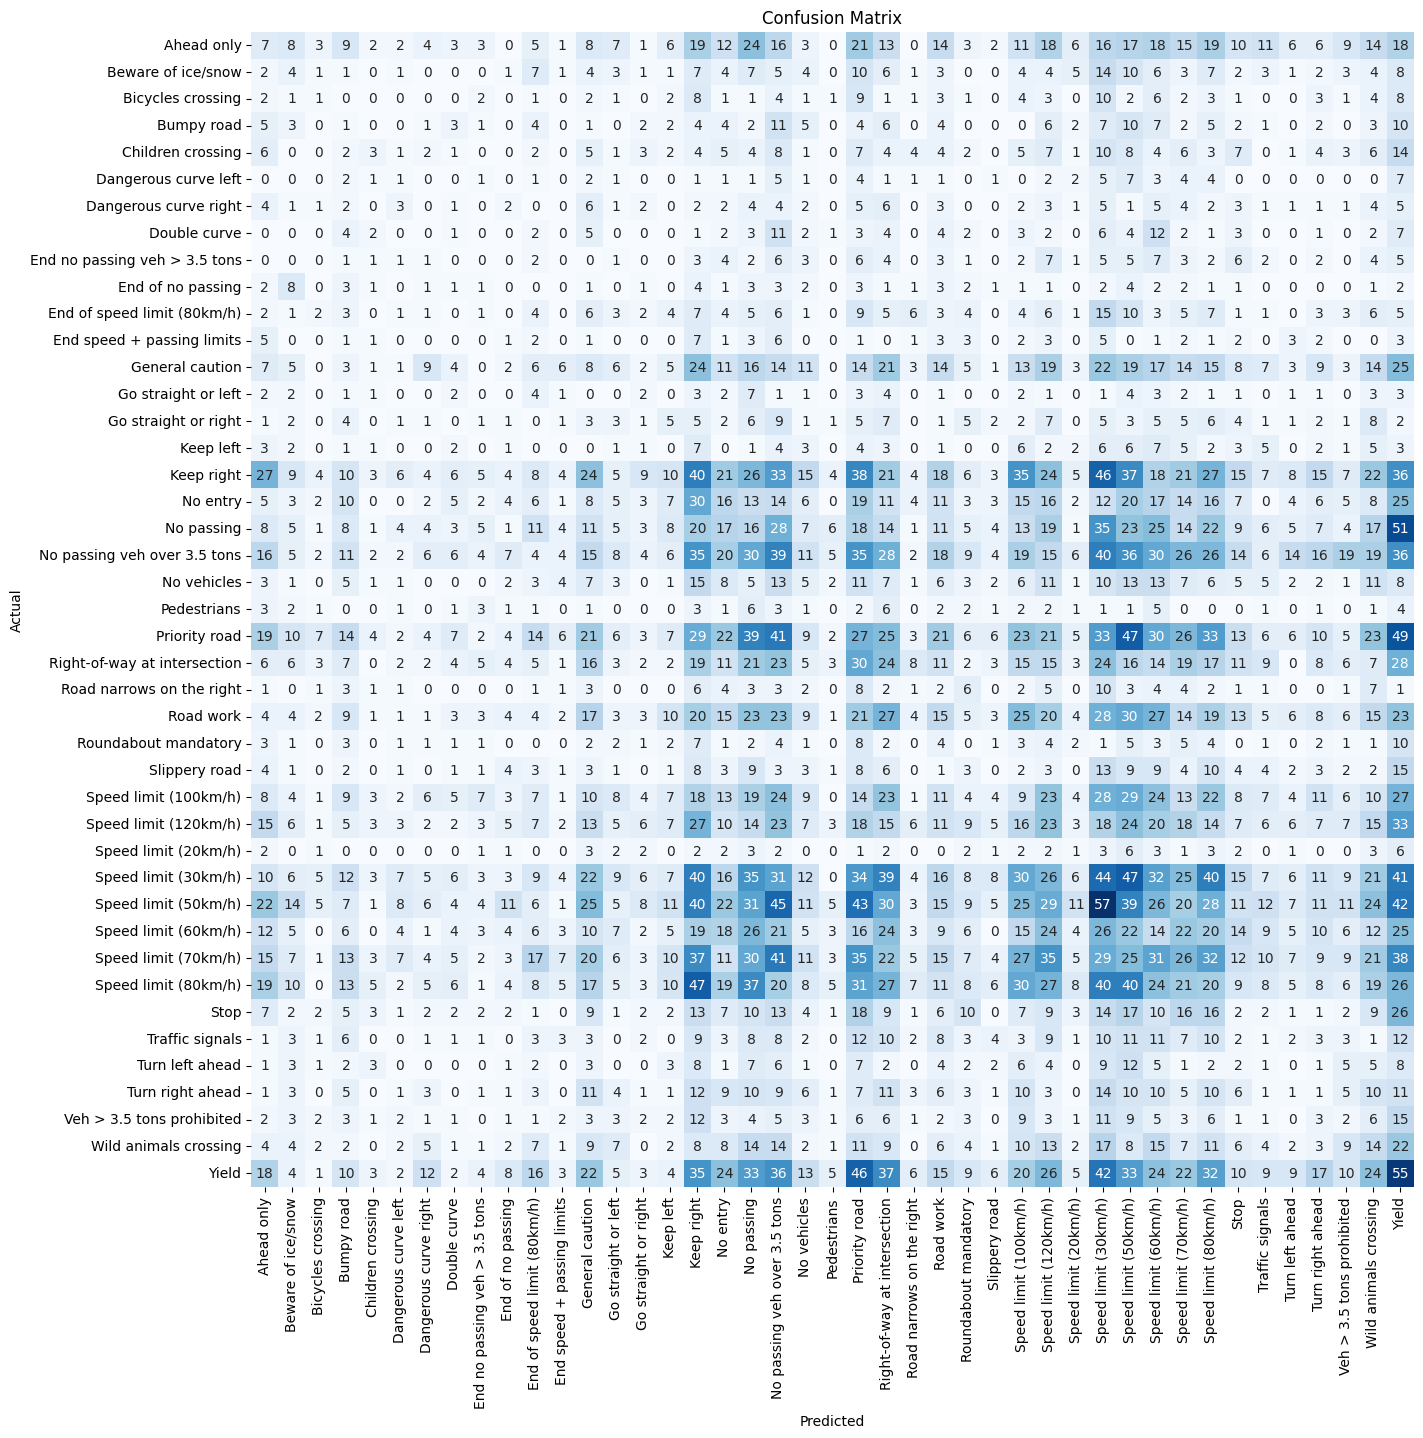

Classification Report:
----------------------
                                precision    recall  f1-score   support

                   Ahead only       0.00      0.00      0.00         0
           Beware of ice/snow       0.00      0.00      0.00         0
            Bicycles crossing       0.00      0.00      0.00         0
                   Bumpy road       0.00      0.00      0.00         0
            Children crossing       0.00      0.00      0.00         0
         Dangerous curve left       0.00      0.00      0.00         0
        Dangerous curve right       0.00      0.00      0.00         0
                 Double curve       0.00      0.00      0.00         0
End no passing veh > 3.5 tons       0.00      0.00      0.00         0
            End of no passing       0.00      0.00      0.00         0
  End of speed limit (80km/h)       0.00      0.00      0.00         0
   End speed + passing limits       0.00      0.00      0.00         0
              General caution

In [84]:
plot_model_evaluation(model, test_images, 43)

In [ ]:
pred   = np.argmax((model.predict(test_images)), axis= 1)
labels = test_images.labels

In [ ]:
test_dataset

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual     = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(test_images[start_index + i])
plt.show()